In [3]:
import pandas as pd
import seaborn as sns 
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import SelectFromModel
%matplotlib inline

In [115]:
data = pd.read_csv('/Users/pranathiiyer/Downloads/exp_with_label.csv')

In [12]:
data.head()

,Unnamed: 0,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Technology,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Technology,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Technology,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Technology,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Technology,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


For a typlical classification task, we could use multiple features of this dataset to actually classify the industry of a person based on a description. However, we only have access to description and title in our curated dataset amongst other features that do not overlap with this datasset. We thus choose only these two columns as features for our classification task and treat category as our outcome or label that we try to classify. 

In [8]:
data.shape

(244768, 13)

In [116]:
final_data = data[['Category', 'Title', 'FullDescription']]
final_data.groupby(by = 'Category').count()

,Title,FullDescription
Category,,
Business/Finance,70494,70494
Charity/Volunteering,2332,2332
Consulting,3263,3263
Education/Research,15126,15126
Healthcare,21075,21076
Human Resources,7713,7713
Law,3939,3939
Others,53713,53713
Policy/Government/Social Work,3455,3455


We can see that while Business/Finance have the most number of entries, and Charity/Volunteering has few. In order to ensure that we have a fairly equal distribution of classes and this imbalance does not affect our final task at hand, we take the class with the least number of entries (2332) and downsample the other classes to get this number. While we would lose a lot of data in doing so, it also ensures that we don't end up with a biased model for our downstream task. We can always reweigh these classes to ensure better usage of data.

In [117]:
final_data = pd.concat([final_data[final_data['Category']=='Business/Finance'].sample(n=2238),
                        final_data[final_data['Category']=='Charity/Volunteering'].sample(n=2238),
                final_data[final_data['Category']== 'Consulting'].sample(n=2238), 
                final_data[final_data['Category']=='Education/Research'].sample(n=2238),
                final_data[final_data['Category']=='Healthcare'].sample(n=2238),
                final_data[final_data['Category']=='Human Resources'].sample(n=2238),
                final_data[final_data['Category']=='Law'].sample(n=2238),
                final_data[final_data['Category']=='Others'].sample(n=2238),
                final_data[final_data['Category']=='Policy/Government/Social Work'].sample(n=2238),
                final_data[final_data['Category']=='Technology'].sample(n=2238)]
                )

In [52]:
final_data.groupby(by = 'Category').count()

,Title,FullDescription
Category,,
Business/Finance,2238,2238
Charity/Volunteering,2238,2238
Consulting,2238,2238
Education/Research,2238,2238
Healthcare,2238,2238
Human Resources,2238,2238
Law,2238,2238
Others,2238,2238
Policy/Government/Social Work,2238,2238


In [118]:
final_data['length'] = final_data['FullDescription'].apply(len)

<Figure size 14760x1440 with 0 Axes>

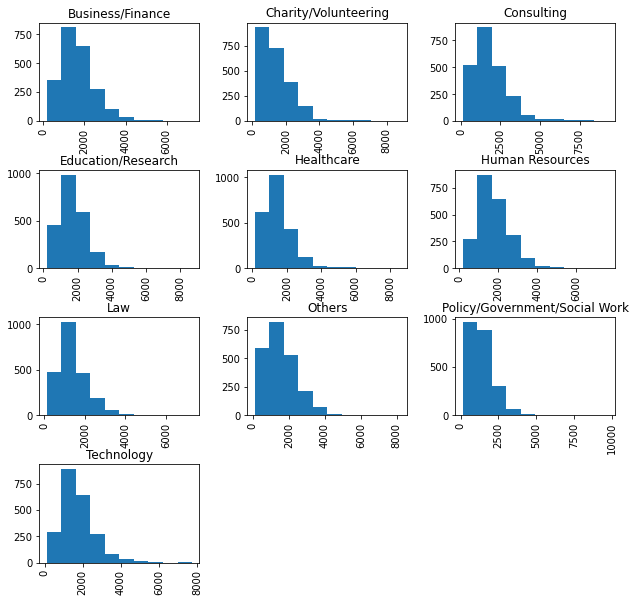

In [92]:

plt.figure(figsize=(205 ,20))
final_data.hist(column='length', by='Category',figsize=(10,10))
plt.show()

In [11]:
final_data.isna().sum()

Category           0
Title              0
FullDescription    0
length             0
dtype: int64

We have no missing values! Let's take a look at what a description actually looks like!

In [93]:
pd.set_option('display.max_colwidth', -1)
final_data['FullDescription'].head(1)

/var/folders/sn/_p253mqn075638n3rt6km5l00000gn/T/ipykernel_61525/1487929974.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


80143    Store Manager We re making history. What part will you play? You may not be aware that GAME has recently been bought and a very exciting future lies ahead. We are investing in our key stores and bringing the best talent into the organisation to build the Number One specialist video games retailer in the UK. We are currently recruiting for a Store Manager for a fantastic GAME store in Bolton, Greater Manchester. It s an exciting place to work with a great location, with the potential to deliver fantastic results and to progress your career further. We are looking for a dynamic, inspirational Store Manager to play a key role in delivering even better results whilst maintaining a welcoming, efficient and safe environment for our customers and staff alike. About You We are looking for Store Managers, ideally with a passion for gaming, who are able to demonstrate the following: Proven track record of success in a management position within retail or a similar environment Experience

Clearly, this needs to be preprocessed

In [55]:
def clean_text(row):
    
    row = re.sub(r"n\'t", " not", row)
    row = re.sub(r"n\'ll", " will", row)
    row = re.sub(r"n\'ve", " have", row)
    row = re.sub(r"n\'t", " not", row)
    row = re.sub(r"i.e", " ", row)
    row = re.sub(r"n\'s", "", row)
    row = re.sub("[^a-zA-Z]"," ", row)
    white_space = re.compile(r"\s+")
    row = white_space.sub(" ", row).strip()
    return row 

In [119]:
final_data['FullDescription'] = (final_data['FullDescription']).apply(lambda row: clean_text(row))

In [39]:
final_data['FullDescription'].tail(1)

51264    My serv s have now been reta d by a member of a world leading innovat eng ering company Working closely with OEM s and end users they are market leaders supplying braking clutches and friction material products worldw The position would suit an enthusiastic skilled eng er with experience of sales and hold a minimum of ONC HND qualifications in mechanical eng ering You will be working with a well known company in an exciting and challenging role You must be able to problem solve and explain technical solutions to customers A knowledge of clutches brakes and friction material is desirable You will be working with a small team and you will be requ d to develop new bus ss whilst maximising and maintaining sales to existing customers Good communication skills are essential you must be computer l rate and a knowledge in CRM reporting procedures would be an advantage Along with the sales role you will also be responsible for planning project management and progress reporting Predomin

## Feature representation
We now move to feature representation of the title and description

In [122]:
final_data.reset_index(inplace = True)

Since we would like to use both description and title, we concatenate them into one column and then vectorize this column to that we can convert the text to numbers that the model can understand.

In [120]:
final_data["concat_text"] = final_data.FullDescription.astype(str) + final_data.Title.astype(str)

In [123]:
stopwords = set(['i','l','my','it','off','means','if','you','husband','do','what','and','a','an'
             'is','for','this','after','the','so','to','m', 'that','into','those','were','was',
             'other','some','are','now','ry','at','serv','t','s','rece',
             'in','don','adv','word','let','her','him','he','she','them','they','be','been',
             've','some', 'such','qu','same','only','up','here','there','do','very','over',
             'but','via','felt','who','whom','whose','where','how','about','just','most','has',
             'had','have','way','back','front','let','flow','sun','del','your','move','got','air',
              'breath', 'dude','know','mean','pan','means','mine','both','with','another','bit',
              'clumps','needs','room','code','one','ones','f', 'em','as','n','cho','me','descr',
              'pr','compet','re','could','would','should','even','r','out','their','n','ly','down',
              'from','because','until','unless','while','its','about','all','any','few','too',
              'own','itself','ppl','keep','really','got','AP','close'])

vect = TfidfVectorizer(lowercase = True, stop_words = {'english'}.update(stopwords), max_df = .8, min_df = 3) 
X = vect.fit_transform(final_data.concat_text)

y = final_data.Category

In [60]:
print(X.shape,y.shape)

(22380, 18945) (22380,)


## Logistic Regression

In [43]:
lg = LogisticRegression() 

In [124]:
clf = LogisticRegression(penalty='l2',C = 10)
selector = SelectFromModel(clf, max_features=4113)
X_train_selected = selector.fit_transform(X, y)

/Users/pranathiiyer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [107]:
final_data = final_data.drop(columns = ['index'])

### Splitting data into train and test set

In [125]:
print(np.arange(final_data.shape[0]))
train_idx, test_idx = train_test_split(np.arange(final_data.shape[0]), test_size=0.4, 
                                       shuffle=True, random_state=42)
X_train = X_train_selected[train_idx]
Y_train = y[train_idx]
X_test = X_train_selected[test_idx]
Y_test = y[test_idx]

[    0     1     2 ... 22377 22378 22379]


In [126]:
clf.fit(X_train, Y_train)

/Users/pranathiiyer/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [127]:
y_pred = clf.predict(X_test)

## Looking at the performance!

In [128]:
print(classification_report(Y_test, y_pred))

                               precision    recall  f1-score   support

             Business/Finance       0.56      0.63      0.59       866
         Charity/Volunteering       0.75      0.74      0.74       920
                   Consulting       0.52      0.47      0.49       907
           Education/Research       0.78      0.76      0.77       923
                   Healthcare       0.77      0.75      0.76       905
              Human Resources       0.77      0.75      0.76       866
                          Law       0.95      0.92      0.94       902
                       Others       0.59      0.60      0.60       908
Policy/Government/Social Work       0.71      0.73      0.72       866
                   Technology       0.70      0.76      0.73       889

                     accuracy                           0.71      8952
                    macro avg       0.71      0.71      0.71      8952
                 weighted avg       0.71      0.71      0.71      8952



## Naive Bayes

In [61]:
vect = TfidfVectorizer(stop_words= {'english'}.update(stopwords))
nb = MultinomialNB() 
vect = TfidfVectorizer(lowercase = True, stop_words = {'english'}.update(stopwords), max_df = .7, min_df = 5) 
X = vect.fit_transform(final_data.concat_text)
y = final_data.Category

In [63]:
train_idx, test_idx = train_test_split(np.arange(final_data.shape[0]), test_size=0.4, 
                                       shuffle=True, random_state=42)
X_train = X[train_idx]
Y_train = y[train_idx]
X_test = X[test_idx]
Y_test = y[test_idx]

In [64]:
clf = MultinomialNB(alpha = 1)
clf.fit(X_train, Y_train)

MultinomialNB(alpha=1)

In [65]:
y_pred = clf.predict(X_test)

In [66]:
print(classification_report(Y_test, y_pred))

                               precision    recall  f1-score   support

             Business/Finance       0.52      0.69      0.59       866
         Charity/Volunteering       0.75      0.69      0.72       920
                   Consulting       0.50      0.40      0.45       907
           Education/Research       0.81      0.74      0.77       923
                   Healthcare       0.73      0.76      0.74       905
              Human Resources       0.65      0.78      0.71       866
                          Law       0.93      0.90      0.92       902
                       Others       0.71      0.41      0.52       908
Policy/Government/Social Work       0.64      0.70      0.67       866
                   Technology       0.64      0.77      0.70       889

                     accuracy                           0.68      8952
                    macro avg       0.69      0.68      0.68      8952
                 weighted avg       0.69      0.68      0.68      8952



In [129]:
small_data = pd.read_csv('/Users/pranathiiyer/Downloads/exp_with_label_small.csv')

In [25]:

small_data.groupby(by = 'industry').count()

,Unnamed: 0,description,company,position
industry,,,,
Business/Finance,256,256,256,256
Charity/Volunteering,119,119,119,119
Consulting,36,36,36,36
Education/Research,398,398,398,398
Healthcare,51,51,51,51
Human Resources,46,46,46,46
Law,116,116,116,116
Others,688,688,688,688
Policy/Government/Social Work,99,99,99,99


In [130]:
small_data['description'] = (small_data['description']).apply(lambda row: clean_text(row))

In [131]:
small_data["concat_text"] = small_data.description.astype(str) + small_data.position.astype(str)

In [132]:
vect = TfidfVectorizer(lowercase = True, stop_words = {'english'}.update(stopwords), max_df = .5, min_df = 2) 
X = vect.fit_transform(small_data.concat_text)
y = small_data.industry

In [133]:
y_pred = clf.predict(X)

In [40]:
print(classification_report(y, y_pred))

                               precision    recall  f1-score   support

             Business/Finance       0.13      0.15      0.14       256
         Charity/Volunteering       0.05      0.13      0.08       119
                   Consulting       0.01      0.06      0.01        36
           Education/Research       0.22      0.09      0.13       398
                   Healthcare       0.00      0.00      0.00        51
              Human Resources       0.03      0.11      0.04        46
                          Law       0.03      0.01      0.01       116
                       Others       0.42      0.23      0.30       688
Policy/Government/Social Work       0.02      0.04      0.03        99
                   Technology       0.04      0.03      0.03       238

                     accuracy                           0.13      2047
                    macro avg       0.10      0.08      0.08      2047
                 weighted avg       0.21      0.13      0.15      2047

